# Introduction
This notebook presents an analysis comparing the performance of two distinct models in predicting car prices: Convolutional Neural Network (CNN) and Random Forest regression. While both models aim to predict car prices, they take different approaches. The CNN processes car images, extracting features from visual data, while the Random Forest model leverages structured data such as the car's year, mileage, and other attributes. This comparison sheds light on the strengths and weaknesses of each approach, offering insights into their applicability and effectiveness in the context of car price prediction.


# Import Required Libraries
In this section, we import all necessary libraries required for data handling, machine learning modeling, and visualization.


In [ ]:
import pandas as pd  # Pandas is a powerful data manipulation library used for data analysis and manipulation.
from pathlib import Path  # Pathlib is a module for working with filesystem paths in an object-oriented way.
from google.colab import drive  # Google Colab library for mounting Google Drive to access files.
from fastai.tabular.all import *  # Fastai library for deep learning tasks with tabular data.
from fastai.vision.all import *  # Fastai library for deep learning tasks with computer vision.
from fastai.metrics import rmse  # Root Mean Squared Error metric from Fastai library.
import matplotlib.pyplot as plt  # Matplotlib is a plotting library for creating static, animated, and interactive visualizations.
from PIL import Image  # Python Imaging Library for opening, manipulating, and saving many different image file formats.
from sklearn.model_selection import train_test_split  # Library for splitting datasets into training and testing sets.
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Libraries for data preprocessing such as one-hot encoding and standardization.
from sklearn.compose import ColumnTransformer  # ColumnTransformer for applying different preprocessing to different columns.
from sklearn.pipeline import Pipeline  # Pipeline for chaining multiple processing steps together.
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regressor model from scikit-learn for regression tasks.

# Setup and Data
Here, we mount Google Drive to access the dataset and define paths to our data. We also load the dataset into a pandas DataFrame.


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths and load dataset
cars_data_directory = '/content/drive/My Drive/cars_dataset/'
cars_data_images = '/content/drive/My Drive/cars_photos/symbol/'
cars_data_file = Path(cars_data_directory) / 'CNN_symbol'
df = pd.read_csv(cars_data_file)
df['image_path'] = cars_data_images + df['filename']
df = df[['image_path', 'Brand', 'Model', 'Year', 'Mileage', 'Color', 'Body', 'Transmission', 'Engine', 'Fuel', 'price']]

Mounted at /content/drive


# Data Preprocessing
We prepare the structured data for regression, set up preprocessing pipelines for scaling and encoding, and split the data into training and test sets, setup blocks and data loaders for image-based model training.


In [ ]:
# Preprocessing for tabular data
X = df[['Year', 'Mileage', 'Brand', 'Model', 'Color', 'Body', 'Transmission', 'Engine', 'Fuel']]
y = df['price']

# Define preprocessing pipeline
cat_names = ['Brand', 'Model', 'Color', 'Body', 'Transmission', 'Engine', 'Fuel']
cont_names = ['Year', 'Mileage']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont_names),
        ('cat', OneHotEncoder(), cat_names)
    ])

reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up data blocks and data loaders for image-based model training
path = Path(cars_data_images)
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('image_path'),
    get_y=ColReader('price'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(mult=2)
)
dls = dblock.dataloaders(df, bs=16)

# Fit Random Forest regression pipeline
reg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Mileage']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Brand', 'Model', 'Color',
                                                   'Body', 'Transmission',
                                                   'Engine', 'Fuel'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# CNN Model Training
We configure and train a CNN model using the Fastai library to handle image data. The model is fine-tuned for our specific task.


In [ ]:
# Define CNN architecture using transfer learning with a ResNet34 backbone
learn = cnn_learner(dls, resnet34, y_range=(min(df['price']), max(df['price'])), metrics=rmse)

# Fine-tune the CNN model on the dataset
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 133MB/s]


epoch,train_loss,valid_loss,_rmse,time
0,3324.301025,5611.713867,74.911377,00:27


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,_rmse,time
0,2861.250488,4533.767578,67.333260,00:20
1,2889.104980,4190.833008,64.736641,00:18
2,2911.956787,3012.536865,54.886581,00:17


# Comparing CNN and Random Forest Predictions on Test Data
Finally, we implements a comparison between predictions generated by a Convolutional Neural Network (CNN) and a Random Forest regressor using a test dataset. It iterates through each row of the test dataset, retrieving image data for CNN predictions and structured data for Random Forest predictions. The actual prices, CNN predictions, and Random Forest predictions are then stored in separate lists for evaluation. This approach allows for a comprehensive examination of the performance of both models across different data types, providing insights into their predictive capabilities in real-world scenarios.


In [ ]:
cnn_preds = []
reg_preds = []
actual_prices = []

for i in range(len(X_test)):
    row = X_test.iloc[i]
    actual_prices.append(y_test.iloc[i])

    # Predict with CNN
    image_path = df[df['Year'] == row['Year']]['image_path'].iloc[0]
    img = PILImage.create(image_path)
    pred, tensor_pred, probs = learn.predict(img)
    cnn_pred = tensor_pred.item()
    cnn_preds.append(cnn_pred)

    # Predict with Random Forest
    structured_df = reg_pipeline.named_steps['preprocessor'].transform(pd.DataFrame([row]))
    reg_pred = reg_pipeline.named_steps['regressor'].predict(structured_df)[0]
    reg_preds.append(reg_pred)

# Visualizing Predictions: Actual vs. Predicted Prices
This visualization aids in assessing the performance and accuracy of both models in predicting prices across the dataset.

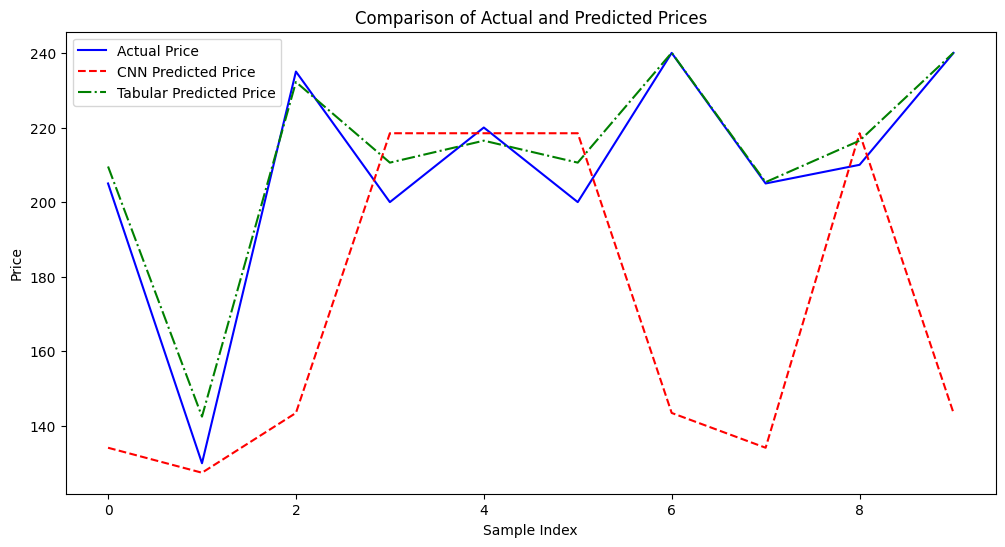

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(cnn_preds, label='CNN Predicted Price', color='red', linestyle='--')
plt.plot(reg_preds, label='Tabular Predicted Price', color='green', linestyle='-.')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()